# Battle Royale Survival Rate
## Math concepts for developers final project
**Author: Viktor Georgiev**  
**Date: May 2025**

### Introduction
Let us face it — everybody has at least once in their life played a game like PUBG, Fortnite, Call of Duty Warzone / Mobile, or something similar. 
In recent times, TV series like *Squid Game* and *Alice in Borderland* have further popularized the idea, which possibly started with the *Hunger Games* book series.

This project simulates a simplified Battle Royale scenario and uses **probability theory**, **stochastic simulation**, and **statistical analysis** to estimate each player’s survival chances. 
The results help answer questions like:

- How does initial skill influence survival?
- How many rounds are typically needed until only one survives?

---

### Project goals
- Model a **simplified Battle Royale** with `N` players.
- Implement **random encounters** between players, with probabilistic outcomes based on skill.
- Use **Monte Carlo simulation** to estimate survival rates.
- Apply **probability**, **combinatorics**, and **basic Markov modeling** to understand outcomes.
- Visualize key results using graphs and plots.
- Explore potential **strategic insights** based on survival analysis.

### Methodology overview
- Define a set of players, each with a skill rating.
- Determine outcome of each encounter using **probabilistic rules**.
- Repeat the process until only one player remains.
- Run thousands of simulations to gather statistics.
- Analyze results using probability theory and visualization.
- Make statistical analysis

---

### Tools and Concepts
- Probability and Conditional Probability
- Random Variables and Expected Value
- Monte Carlo Simulation
- Markov Chains (absorbing state modeling)
- Statistical Visualization

---

In [1]:
# Imports
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from functions_logic.player import Basic_Player, Player_With_Strategy, Player_With_Injury_Sickness, Player_With_Teams, Player_With_Initial_Zone, Final_Player
from functions_logic.zone import Zone
from functions_logic.utils import generate_random_players
from functions_visualization.plots import *

## General rules of the simulator and maths

### 1. Player Attributes: Gender, Age and Background

- Gender: This could affect the base skill (e.g., male players could have a higher average skill based on physicality in combat, while female players may have a different strategy).
- Age: The skill of a player decreases with age, especially above 50. This could be represented as a function where the skill **S** decreases as age **A** increases
$$S_{age}(A) = S_{base} * (1 - 0.05 * max(0, A - 50))$$

This formula represents a 5% decrease in skill for every year above 50. For ages below 50, the skill remains the same.

- Backgrounds: Different backgrounds provide different advantages, such as:
    * Programmer: Better at strategy, with higher chance of survival when hiding or avoiding conflict.
    * MMA Fighter: Higher combat skill, but lower strategy or survival when hiding.
    * Soldier: Balanced in combat and survival.
    * Doctor: Can heal or reduce injuries, improving survival chances.
    * Construction worker: Can use equipment better
    * Others

We can model these advantages by adding background multipliers to the base skill:
$$
S_{\text{background}} = S_{\text{base}} \times M_{\text{background}}
$$

where $M_{background}$ is a multiplier based on the background (e.g. MMA fighter $M_{MMA}$ = 1.2, Doctor $M_{doctor}$ = 1.1)

---


### 2. Strategies

Players can adopt different strategies during the game, which affect their survival probability. We can represent this as a conditional probability:

- **Aggressive strategy**:  Higher risk of death but higher chance of eliminating opponents.
- **Hiding strategy**: Lower risk of death, but lower chance of eliminating opponents.
- **Balanced strategy**: Mix of both

We can use a strategy modifier $M_{strategy}$ that adjusts the survival probability based on the strategy:

$$P_{survival}(strategy) = P_{base} * M_{strategy}$$

where $M_{strategy}$ could take values based on the strategy chosen (e.g., for aggressive: $M_{aggressive}$ = 0.8, hiding $M_{hiding}$ = 0.8)


---

### 3. Injuries and Sickness

Injuries or sickness can decrease a player's survival probability. Let’s define a probability reduction factor $R_{injury}$ or $R_{sickness}$ based on the severity of the condition:

$$P_{survival} = P_{base} * (1 - R_{injury}) * (1 - R_{sickness})$$

where:

$R_{injury}$ and $R_{sickness}$ are factors between 0 and 1, where 1 represents a fatal injury or sickness.

---

### 4. Team Dynamics

When players with similar backgrounds team up, they can boost each other’s survival chances. This can be modeled using a cooperative multiplier $M_{team}$

$$P_{survival | team} = P_{base} * M_{team}$$

where $M_{team}$ > 1 (e.g. $M_{team}$ = 1.2) if the players have compatible backgrounds (e.g., two soldiers teaming up).

---

### 5. Zone shrinking
The shrinking game zone could be modeled as a deterministic function where players outside the zone die or suffer a survival penalty. If the player is outside the zone, their survival probability becomes 0, otherwise:

\[
$P_{survival|zone}$ = 
\begin{cases}
0, & \text{if player is outside the zone} \\
P_{\text{base}}, & \text{if player is inside the zone}
\end{cases}
\]


The shrinking zone itself can be modeled with a time-dependent radius $r(t)$ where $r$ decreases as time progresses:

$$r(t) = r_{0} - k * t$$

where $r_{0}$ is the initial radius and $k$ is the shrink rate

--- 

### 6. Weapons and Items

Weapons found during the game can boost the player's skill or alter the outcome of encounters. We can model the weapon effect as a multiplier:

$$S_{weapon} = S_{base} * M_{weapon}$$

where $M_{weapon}$ is  is a multiplier based on the type of weapon (e.g., a gun might have $M_{weapon}$ = 1.5)


---

### 7.Overall Survival Probability

Combining all factors we get this formula:

$$P_{survival} = P_{base} * M_{age} * M_{background} * M_{strategy} * (1 - R_{injury}) * (1 - R_{sickness}) * M_{team} * M_{weapon} * P_{zone}$$

This formula accounts for all the factors affecting a player’s survival.

---

### 8. Bayesian Inference for Dynamic Updates

- **Context**: As the game progresses, new information (such as injuries, encounters, weapons found) becomes available. We can use **Bayesian Inference** to update the survival probabilities dynamically as new data comes in.
- **How to use it**:
    * Each player has a prior survival probability $P\frac{prior}{survival}$ based on their initial conditions (e.g., age, gender, background).
    * As the game progresses, new observations (such as successful encounters or injuries) can be used to update the survival probability using Bayes’ Theorem:

$$P_{survival|data} = \frac{P_{(data|survival)} * P_{survival}}{P_{data}}$$

This allows the simulation to adjust each player's survival probability as they encounter new challenges or make progress through the game.

---


#### Age penalty
Let us see how age penalty can affect the skill of a player

In [ ]:
# Let us check if the age penalty and background multiplier and gender multiplier are working as expected. We will use the basic player class for this.
# It does not have too much logic and is easy to understand.

strategies = ["balanced", "hiding", "aggressive"]
for age in range(45, 61, 3):
    p = Basic_Player("Test", "male", age, "soldier", "balanced")
    print(f"Age {age} => Skill: {p.skill:.2f}")
    
backgrounds = ['programmer', 'mma_fighter', 'soldier', 'doctor', 'construction_worker', 'default']
for bg in backgrounds:
    p = Basic_Player("Test", "male", 30, bg, random.choice(strategies))
    print(f"Background: {bg} => Skill: {p.skill:.2f}")
    


#### Plotting skill difference based on age
This clearly shows that the logic is working

In [ ]:
# --- Plot for Age vs Skill ---
ages = range(45, 61, 3)
age_skills = [Basic_Player("Test", "male", age, "soldier").skill for age in ages]

# Plot Age vs Skill
plt.figure(figsize=(10, 6))
plt.plot(ages, age_skills, marker='o', linestyle='-', color='b', label='Soldier')

plt.title("Survival Skill vs Age", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Survival Skill", fontsize=12)
plt.grid(True)
plt.xticks(ages)
plt.legend()
plt.show()

# --- Plot for Background vs Skill ---
backgrounds = ['programmer', 'mma_fighter', 'soldier', 'doctor', 'construction_worker', 'default']
bg_skills = [Basic_Player("Test", "male", 30, bg).skill for bg in backgrounds]

# Plot Background vs Skill
plt.figure(figsize=(10, 6))
plt.bar(backgrounds, bg_skills, color=['blue', 'orange', 'green', 'red', 'purple', 'gray'])

plt.title("Survival Skill vs Background", fontsize=16)
plt.xlabel("Background", fontsize=12)
plt.ylabel("Survival Skill", fontsize=12)
plt.grid(True, axis='y')
plt.show()

#### Adding strategy
Let us add strategy to the mix and check how things will change

In [ ]:
p1 = Player_With_Strategy("Alex", "male", 28, "soldier", "aggressive")
p2 = Player_With_Strategy("Sophie", "female", 34, "doctor", "hiding")
p3 = Player_With_Strategy("Jake", "male", 51, "mma_fighter", "balanced")

print(p1)
print(p2)
print(p3)

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Player strategy affecting skill")
plt.bar([f"{p1.name} - {p1.strategy}", f"{p2.name} - {p2.strategy}", f"{p3.name} - {p3.strategy}"], [p1.skill, p2.skill, p3.skill], color=['blue', 'orange', 'green'])
plt.xlabel("Player")
plt.ylabel("Skill")
plt.xticks(rotation=45)
plt.show()

There is a difference in the overall skill, so it looks like it is working as expected

#### Adding injury methods and sickness

In [ ]:
p1 = Player_With_Injury_Sickness("Sam", "male", 40, "soldier", "aggressive")
print(p1)
p1.apply_injury(0.3)
print(p1)
p1.apply_sickness(0.2)
print(p1)

We can see a definitive change in the survival probability when injury and/or sickness are is applied.
Let us now visualize this with a larger data base

In [ ]:
injury_severities = np.linspace(0, 1, 100) # define a range of injury severities from 0 to 1
p1 = Player_With_Injury_Sickness("Sam", "male", 40, "soldier", "aggressive")
injury_survival = [p1.apply_injury(severity) or p1.get_survival_probability() for severity in injury_severities] # do 100 iterations of the injury severity

# --- Plot Sickness vs Survival ---
sickness_severities = np.linspace(0, 1, 100) # define a range of sickness severities from 0 to 1
sickness_survival = [p1.apply_sickness(severity) or p1.get_survival_probability() for severity in sickness_severities] # do 100 iterations of the sickness severity

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot for Injury Severity vs Survival Probability
plt.subplot(1, 2, 1)
plt.plot(injury_severities, injury_survival, color='r', label="Injury Impact")
plt.title("Survival Probability vs Injury Severity")
plt.xlabel("Injury Severity")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()

# Plot for Sickness Severity vs Survival Probability
plt.subplot(1, 2, 2)
plt.plot(sickness_severities, sickness_survival, color='b', label="Sickness Impact")
plt.title("Survival Probability vs Sickness Severity")
plt.xlabel("Sickness Severity")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**By running the code above, we can see that the player has a different survival P after injury and/or sickness** 

#### Adding teams and weapons to the mix :D

**Let us check how things are looking so far**

In [ ]:
# base survival
p1 = Player_With_Teams(name="Test1", age=30, gender="male", background="soldier", strategy="balanced")
print(f"Base survival: {p1.get_survival_probability()}")  # Expect around 1.15 (since soldier has 1.15 multiplier)
print(f"Is alive (Should be true): {p1.is_alive}")  # Should be True

# Age over 50
p2 = Player_With_Teams(name="OldMan", age=60, gender="male", background="soldier", strategy="balanced")
print(f"Age over 50: {p2.get_survival_probability()}")  # Expect significant reduction due to age
print(f"Is alive (Should be true): {p1.is_alive}")  # Should be True

# Injury over 1 (fatal)
p3 = Player_With_Teams(name="Injured", age=30, gender="female", background="doctor", strategy="hiding", injury_severity=1.0)
print(f"Injury: {p3.get_survival_probability()}")  # Should be 0.0
print(f"Is alive: {p3.is_alive}")  # Should be False

# Weapon effect
p4 = Player_With_Teams(name="Armed", age=25, gender="female", background="programmer", strategy="aggressive", has_weapon=True)
print(f"Survival with weapon: {p4.get_survival_probability()}")  # Should be increased by 1.5x multiplier
print(f"Is alive (Should be true): {p1.is_alive}")  # Should be True

# Team bonus
teammate = Player_With_Teams(name="Buddy", age=30, gender="male", background="soldier", strategy="balanced")
p5 = Player_With_Teams(name="TeamPlayer", age=30, gender="male", background="soldier", strategy="balanced", teammates=[teammate])
print(f"Survival with team: {p5.get_survival_probability()}")  # Should include team multiplier (1.2)
print(f"Is alive (Should be true): {p1.is_alive}")  # Should be True

# Edge case (should be 0)
p6 = Player_With_Teams(name="DeadMan", age=80, gender="male", background="doctor", strategy="balanced", injury_severity=1.0, sickness_severity=1.0)
print(f"Should be dead (Result must be 0): {p6.get_survival_probability()}")  # Should be 0.0
print(f"Is alive: {p6.is_alive}")  # Should be False

**Results look good**

#### Defining the initial zone class
Players will die if they are outside the zone (0 chance of survival)

##### Let us run a simulation with all of the logic so far

In [ ]:

# Example usage: Run a simulation with all the logic so far

# -----------------------
# Run simulation
# -----------------------
# Plotting function
def plot_players(players, round_num, zone):
    """Plot the players' positions and survival probabilities with legend."""
    plt.figure(figsize=(8, 8))

    # Filter alive players
    alive_players = [p for p in players if p.is_alive]

    x_positions = [p.x for p in alive_players]
    y_positions = [p.y for p in alive_players]
    survival_probs = [p.get_survival_probability(zone) for p in alive_players]

    # Plot players
    scatter = plt.scatter(
        x_positions,
        y_positions,
        c=survival_probs,
        cmap='viridis',
        s=100,
        edgecolors='black',
        label='Players'
    )

    # Annotate each point with the player's name
    for player in alive_players:
        plt.annotate(player.name, (player.x, player.y), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

    # Plot zone as a circle
    circle = plt.Circle((zone.center_x, zone.center_y), zone.radius, color='red', fill=False, linestyle='--', linewidth=2, label='Zone')
    plt.gca().add_patch(circle)

    # Colorbar and plot settings
    plt.colorbar(scatter, label="Survival Probability")
    plt.title(f"Round {round_num} - Player Positions and Survival Probability")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(-110, 110)
    plt.ylim(-110, 110)
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


zone = Zone()
players = generate_random_players(10, Player_With_Initial_Zone)

# Assign teammates with the same background (optional team logic)
for p in players:
    p.teammates = [other for other in players if other != p and other.background == p.background]

# Simulate rounds
for round_num in range(1, 6):
    print(f"\n--- Round {round_num} ---")
    zone.shrink()

    # Update player status and move players
    for p in players:
        if p.is_alive:
            p.move()
            p.update_status()
            prob = p.get_survival_probability(zone)
            # Probabilistic death check
            # Probabilistic death check
            if random.random() > prob:
                p.is_alive = False
                print(f"{p.name} has died.")
            print(f"{p.name} ({p.background}) | Pos: ({round(p.x, 1)}, {round(p.y, 1)}) | Prob: {prob} | Alive: {p.is_alive} | Inside zone: {p.is_inside_zone(zone)}")
    
    # Plot the players for the current round
    plot_players(players, round_num, zone)

**We can see that the zone is now correctly impacting the survival of a player. However, a player should not technically die if outsize the zone, just have a harder time surviving.Let us work with this.Another issue is that at the moment, the chance of survival is technically bigger, because you only "die" if you are outside of the zone, which does not have a big chance to happen. This can be seen at the small change to the probability after each round**

#### Change the class and do the same simulation to check what will happen when the player does not die when outside of the zone, but just has a lower chance of survival.

Player class is changed so instead of the player dying if outside of the zone, he has a 30% less chance to survive

$$P_{\text{outside of zone}} = \frac{P \times 30}{100}$$


---


In [ ]:
zone = Zone()
players = generate_random_players(10, Final_Player)

for round_num in range(1, 6):
    print(f"\n--- Round {round_num} ---")
    zone.shrink()

    for player in players:
        if player.is_alive:
            player.move()
            player.update_status()
            prob = player.get_survival_probability(zone)
            # Probabilistic death check
            if random.random() > prob:
                player.is_alive = False
                print(f"{player.name} has died.")
            print(f"{player.name} | Pos: ({round(player.x,1)}, {round(player.y,1)}) | Survival Prob: {prob} | In Zone: {zone.is_inside(player.x, player.y)} | Has weapon: {player.has_weapon} | Is alive: {player.is_alive} | Is inside zone: {player.is_inside_zone(zone)}")
    plot_players(players, round_num, zone)

**We can now see far better results than before. Technically, every player has a chance of survival if probability is more than 0, so I will not make a certain death due to the zone or too low chance. Now, the results correctly show a bigger difference in the survival probability when outside of the zone, but the player still has a survival chance.**

Furthermore, we can see players outside of the zone who are alive, but also players who are inside the zone, but have died. This is very important for the realism of our project

---

## Simulations with Monte Carlo to determine probability over many battle royals

### We are going to use monte carlo simulations for making predictions as realistic as possible

#### Quick introduction to monte carlo simulations:

Monte Carlo simulations are a way to use random sampling to solve problems that might be too complex to solve exactly.

In simple terms:
- You run **lots of random trials** or experiments.
- Each trial simulates a possible outcome based on chance.
- By looking at the results of all these trials, you can estimate probabilities, averages, or risks.

For example, if you want to know the chance of winning a game with many uncertain factors, you simulate the game thousands of times randomly and see how often you win.

It’s like **playing out many “what if” scenarios** on a computer to understand likely results.


In [2]:
# Monte carlos simulations function

async def monte_carlo_simulations(players, zone, num_simulations = 1000):
    survival_counts = {player.name: 0 for player in players}  # Track how many times each player survives
    
    for sim in range(num_simulations):
        # Copy players to avoid modifying the original player objects
        trial_players = [Final_Player(player.name, player.age, player.gender, player.background, player.strategy, player.injury_severity, player.sickness_severity, player.has_weapon, player.teammates) for player in players]
        for p in trial_players:
            p.is_alive = True # make all players alive at the start of each simulation
        trial_zone = Zone() # need new zone each time, otherwise the zone is too small and everyone dies
        # Simulate the game until only one player remains
        while len([player for player in trial_players if player.is_alive]) > 1:
            trial_zone.shrink()  # Shrink the zone for each round, use new zone each time

            for player in trial_players:
                if player.is_alive:
                    player.move()
                    player.update_status()
                    prob = player.get_survival_probability(zone)
                    # Probabilistic death check
                    if random.random() > prob: # generate a random number between 0 and 1 (float), survival is all up to chance that way
                        player.is_alive = False
                        
        # After the loop ends, the last remaining player is the winner
        for player in trial_players:
            if player.is_alive:
                survival_counts[player.name] += 1
                
        # Calculate the probability of survival for each player
    survival_probabilities = {name: count / num_simulations for name, count in survival_counts.items()}
    return survival_probabilities

### Example (Test)
Run a simulation with 100 randomly generated players 1000 times and check the results

In [3]:
zone = Zone()
players = generate_random_players(100, Final_Player) # each battle royal match is with 100 people
survival_probabilities = await monte_carlo_simulations(players, zone, num_simulations=1000)

# Print out survival probabilities for each player
for player_name, survival_prob in survival_probabilities.items():
    print(f"{player_name}: Survival Probability = {survival_prob:.4f}")

Player1 - mma_fighter - hiding: Survival Probability = 0.0060
Player2 - mma_fighter - balanced: Survival Probability = 0.0110
Player3 - doctor - aggressive: Survival Probability = 0.0020
Player4 - programmer - balanced: Survival Probability = 0.0110
Player5 - construction_worker - hiding: Survival Probability = 0.0020
Player6 - programmer - aggressive: Survival Probability = 0.0000
Player7 - mma_fighter - hiding: Survival Probability = 0.0000
Player8 - soldier - hiding: Survival Probability = 0.0140
Player9 - soldier - hiding: Survival Probability = 0.0070
Player10 - soldier - balanced: Survival Probability = 0.0810
Player11 - soldier - hiding: Survival Probability = 0.0040
Player12 - soldier - balanced: Survival Probability = 0.0180
Player13 - mma_fighter - hiding: Survival Probability = 0.0050
Player14 - mma_fighter - balanced: Survival Probability = 0.0420
Player15 - default - aggressive: Survival Probability = 0.0000
Player16 - default - aggressive: Survival Probability = 0.0000
Pl

### Plot survival chance of players

In [4]:
def plot_survival_probabilities(survival_probabilities):
    # Sort by probability descending
    sorted_probs = dict(sorted(survival_probabilities.items(), key=lambda item: item[1], reverse=True))
    
    names = list(sorted_probs.keys())
    values = list(sorted_probs.values())

    plt.figure(figsize=(20, 16))
    plt.barh(names, values, color='skyblue')
    plt.xlabel("Survival Probability")
    plt.title("Monte Carlo Survival Probabilities per Player")
    plt.gca().invert_yaxis()  # Highest probability on top
    plt.tight_layout()
    plt.show()

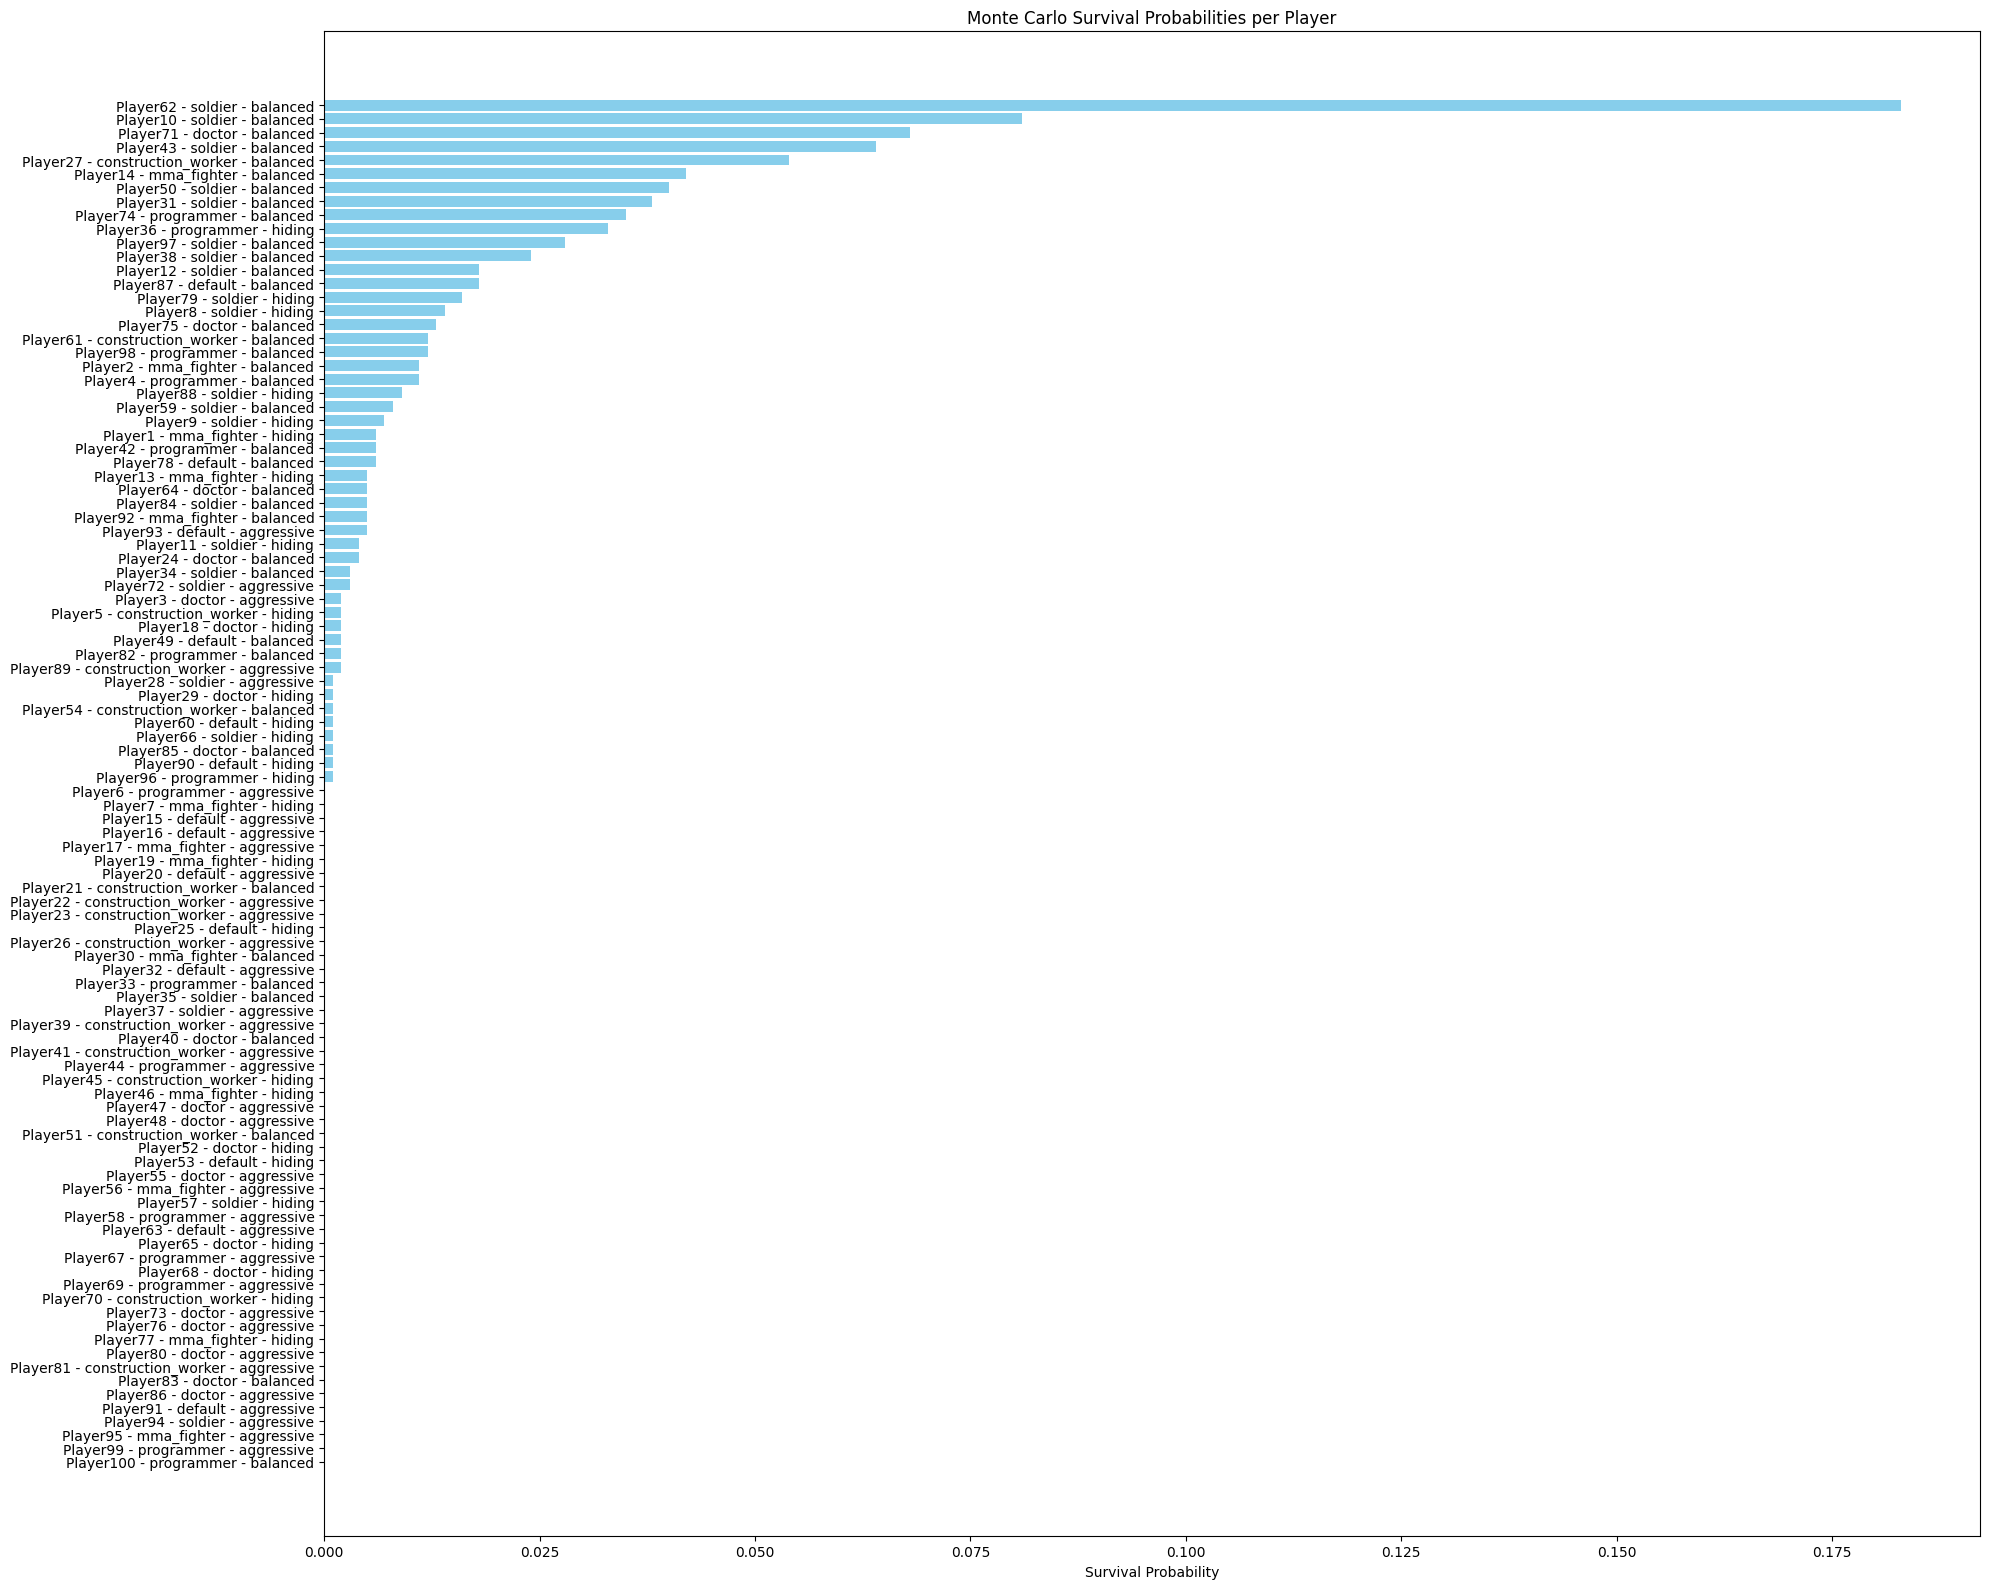

In [5]:
plot_survival_probabilities(survival_probabilities)

### Summary of 1000 Monte Carlo Simulations
Very interesting results. 
We need to bear in mind the overall low survival chance. In our first creations of methods and plots we noticed a higher survival chance, but then we were working on a
round to round basis, so it was naturally higher. Here we are checking the overall survival chance of a person actually winning the whole battle royal outlasting all of the other 99 opponents, so it is normal for it to be a lot lower.

We can see a trend that fighting or very "intelligent" backgrounds with a balance strategy have the biggest survival chance.
It would be interesting to see what will be the overall mean survival rate of a person. In order to calculate this, we can run the 1000 thousand simulations 100 hundred times, take the mean survival rate of all players per run of the simulations and then calculate the mean value. First we calculate the mean survival per iteration of the 1000 simulations
$$\text{Mean survival per 1000 simulations} = \frac{player1_{survival} + player2_{survival} + \cdots player100_{survival}}{100}$$
where 100 is the total amount of players per battle royal game. Then we calculate the total mean 
$$\text{Total mean survival chance} = \frac{\text{mean survival chance 1} + \text{mean survival chance 2} + \cdots + \text{mean survival chance 100}}{100}$$
where 100 is again the total amount of mean survival chances we have calculated

In [7]:
zone = Zone()
players = generate_random_players(100, Final_Player)
total_mean_values = []
for _ in range(100):
    current_mean_values = []
    survival_prob = await monte_carlo_simulations(players, zone, num_simulations=1000)
    for player_name, survival_chance in survival_prob.items():
        current_mean_values.append(survival_chance) 
    current_mean_end_value = np.mean(current_mean_values)
    total_mean_values.append(current_mean_end_value)



Very long time to execute (~ 2 minutes) and my laptop is heating and the fan is running like crazy. Still, it works :D 

---

## Statistical analysis of simulations

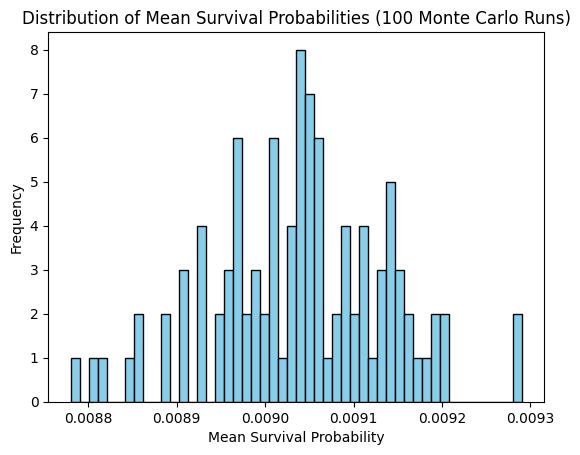

In [13]:
# Plotting the 100 mean survival probs
plt.hist(total_mean_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Mean Survival Probabilities (100 Monte Carlo Runs)")
plt.xlabel("Mean Survival Probability")
plt.ylabel("Frequency")
plt.show()

We can see the distribution by probability. Naturally we can see higher frequency in the middle ground.

### Statistics

In [10]:
# 1. Final mean value
final_mean_survival_chance = np.mean(total_mean_values)
print(f"Final mean survival chance of a random person after 100 times of 1000 simulations with 100 players => {final_mean_survival_chance:.4f}")

# 2. Standard Deviation
standard_deviation = np.std(total_mean_values)
print(f"Standard deviation of all mean values => {standard_deviation:.4f}")

# 3. Confidence Intervals (95%)
ci_low, ci_high = stats.norm.interval(0.95, loc=final_mean_survival_chance, scale=standard_deviation/np.sqrt(len(total_mean_values)))
print(f"Confidence intervals low => {ci_low:.4f}")

# 4. Median, min, max
median = np.median(total_mean_values)
print(f"Median => {median}")
min = np.min(total_mean_values)
print(f"Min => {min}")
max = np.max(total_mean_values)
print(f"Max => {max}")

# 5. Skewness & Kurtosis
# Skewness: asymmetry in distribution
# Kurtosis: how peaked or flat the distribution is
skewness = skew(total_mean_values)
print(f"Skewness => {skewness}")
kurt = kurtosis(total_mean_values)
print(f"Kurt => {kurt}")


Final mean survival chance of a random person after 100 times of 1000 simulations with 100 players => 0.0090
Standard deviation of all mean values => 0.0001
Confidence intervals low => 0.0090
Median => 0.00904
Min => 0.00878
Max => 0.00929
Skewness => -0.14518650450848264
Kurt => 0.12385099476721217


#### Interpretation of Key Findings:
- **Mean survival chance of 0.0091**:

    This value represents the average probability that any randomly chosen player will survive until the end of the game across all simulations. It is very close to the theoretical probability of 0.01 (1/100), which makes sense because there is only one winner out of 100 players in each simulation. This close match shows that the simulation accurately reflects the expected outcome based on simple probability.

- **The very low standard deviation confirms**:"

    The standard deviation measures how much the survival chances vary between the 100 repeated experiments. A very low value means that the survival probabilities are very consistent and don’t fluctuate much from one experiment to another. This indicates the simulation results are stable and reliable, and the model produces reproducible outcomes.
- **The tight confidence interval and small range (min/max)**:

    The confidence interval shows the range within which the true average survival probability likely lies, with a high degree of certainty. The narrow confidence interval and the small difference between the minimum and maximum observed survival chances across experiments demonstrate that the results have converged well. In other words, running more simulations would likely not change the average survival probability significantly.

- **Slight negative skewness suggests**:

    Skewness measures the asymmetry of the distribution of survival probabilities. A slight negative skewness means the distribution leans a bit toward higher survival chances — there are somewhat more instances where players survive slightly better than the average predicted probability. This suggests that in some simulations, players have a small advantage or “luck” that slightly improves their chances of survival compared to a perfectly balanced system.

- **Near-zero kurtosis**:

    Kurtosis describes the “peakedness” or “flatness” of the distribution relative to a normal (bell-shaped) distribution. A kurtosis close to zero means that the shape of the survival probability distribution is very similar to a normal distribution, without heavy tails or extreme outliers. This indicates the variation in survival chances is typical and well-behaved, making the simulation results statistically robust.


---

## Summary of research

#### Interpretation of Simulation Results
After running **100 batches of 1000 simulations each**, with **100 players per simulation**, we obtained the following aggregated statistics:
- Mean survival chance of a random player: 0.0091

These results are remarkably close to the theoretical expectation of $\frac{1}{100} = 0.01$, which is the survival probability in a system where each player has equal chance of being the last survivor. The very low variance and tightly bound distribution indicate a stable **simulation**. 

All other statistical analyses show normal values with no abnormal behaviour. We can say that our tests are stable and make the following summary of the results:
- consistent with theoretical expectations
- Show stability and low variance
- Suggest the simulation is working properly


#### Observed Behavioral Patterns
Further analysis of the simulation outcomes revealed non-uniform survival trends among different player profiles. Specifically:
- Players with professions like **programmers** or **doctors** who chose the **"hiding" or "balanced"** strategy tended to have a higher-than-average survival chance.
- Conversely, players with a **combat-oriented background (such as fighters or soldiers)** who selected **"aggressive" or "balanced"** strategies also showed improved survival outcomes.

####  Interpretation and Real-World Analogy
These results are **consistent with realistic expectations**:
- Hiding/Balanced Strategy **(Programmers/Doctors)**:
    * These players often avoid direct conflict.
    * As "clever" individuals, they may be better at resource management, evasion, and using terrain or situations to survive longer.
    * The hiding strategy works especially well in early and mid-game stages, allowing them to outlive many competitors without needing to win fights.
- Aggressive/Balanced Strategy (Fighters/Soldiers):
    * Players with combat training are more likely to win direct encounters.
    * The aggressive/balanced strategy, when paired with combat experience, allows them to actively eliminate threats and control resource-rich zones.
    * Their real-world-like training gives them an edge in high-pressure, dangerous scenarios.

#### Simulation Fairness vs. Emergent Advantage
Despite the overall fairness (as reflected by the near-uniform average survival rate), these emergent advantages suggest the simulation has **realistic depth**. Rather than hard-coding winners, it allows for **probabilistic advantages** that emerge based on **synergy between player traits and strategies**.

This emergent behavior mimics real-world systems where:
- Intelligence and caution can be powerful defensive tools.
- Combat skills provide offensive power that can dominate if used properly.

#### Suggested Future Work
In future iterations, it may be interesting to:
- Track and visualize **per-strategy** and **per-background** win rates.
- Introduce **adaptive strategies** (e.g., switching from hiding to aggressive as player count drops).
- Model **collaboration and betrayal dynamics** among similar players (e.g., doctors forming teams and later turning on each other).

---




## References
- CHAT-GPT
- How Randomness Affects Player Ability to Predict the Chance to Win at PlayerUnknown’s Battlegrounds (PUBG) => https://webm.ue.katowice.pl/strzelecki/papers/2021-tcgj.pdf
- Battle Royal wiki => https://en.wikipedia.org/wiki/Battle_royale_game
- Call of duty Warzone wiki => https://en.wikipedia.org/wiki/Call_of_Duty:_Warzone
- Hunger Games => https://en.wikipedia.org/wiki/The_Hunger_Games
- Squid Game => https://en.wikipedia.org/wiki/Squid_Game
- Predicting the match outcome of a battle royal game pdf => https://arno.uvt.nl/show.cgi?fid=147794